This notebook is a summery of preprocessing and exploratory data analysis of two set of *meRIP-seq* data from patient with COVID19. For each patient, we have sequence results for both input/IP for each sample. Totally, there are 44 sequencing samples, 22 patients with both IN and RIP. 

Current pipeline contain these steps: 

#### Human genome 
0. Run `bcl2fastq` to make fastq files from raw data
        - input: bcl
        - output: fastq
1. Using `cutadapt` to trim few bps from the sequencing library.
        - input: fastq
        - output: fastq
2. Align to human genome using `STAR` and write unaligned reads in seprate `fastq` files
        - input: fastq
        - output1: bam
        - output2: fastq
3. Call human m6A peaks in each samples using `exomePeak` (see [here](https://bioconductor.riken.jp/packages/3.0/bioc/html/exomePeak.html)) and `gencode.v28.annotation`. 
        - input1: gtf
        - input2: bam
        - output: bed12

4. Taking bed12 results from step 3:
    1. Drawing meta-gene plot using `Guitar` (see [here](https://bioconductor.org/packages/3.11/bioc/html/Guitar.html)). 
    2. Using `cgat` (see [here](https://cgat.readthedocs.io/en/latest/cgat.html)) to prepare FIRE input. 
    2. Motif analysis using `FIRE`
    
Final results reported separately [here](https://github.com/goodarzilab/Abe/blob/master/Projects/COVID19_m6A/human-report.ipynb)

#### Virus genome 
5. Using `STAR` to build index and map COVID19 genome to unaligned reads to the human genome.
    According to Matt's epxeriance ([link](https://github.com/goodarzilab/khorms/blob/master/side_projects/COVID_DMSseq_library.ipynb)), I'm using [this genome annotation](https://www.ncbi.nlm.nih.gov/nuccore/MN908947?%3Fdb=nucleotide). 
        - input: fastq
            output2 of step 2. 
        - output: bam 


6. Using `exomePeak` with custom option that make it work for calling virus peaks. 
        - input1: gtf
        - input2: bam
        - output: bed12

7. Align unmapped reads to human genome to m6A+ and m6A- internal controls. Albertas used controls from [N6-Methyladenosine Enrichment Kit](https://international.neb.com/-/media/nebus/files/manuals/manuale1610.pdf?rev=c064d5e232414f709ef8bccee56f7687&hash=AAA94B8FDA043DD5A610E14686552B5E0209EA94). 
        - input1: bed
        - input2: fasta
            manually created from the above link
        - output: bam


8. For calling peaks, different scenarios tested. Now, I'm making a bed to note all the region

9. Count virus peaks as features using `bamToBed` plus `intersectBed` to count reads that aligned to each peaks. 
        - input1: bam 
            output of step 5.
        - input2: bed
            output1 of step 8. 
        - output: count-matrix 

        
10. Motif analysis using `regex` by extracting the sequence of each peaks and quary patterns
        - input: fasta
            output2 of step 8. 
        - output: motif-dataframe


12. Implement R code from [here](https://github.com/lzcyzm/exomePeak/blob/master/R/ctest.R) to run `ctest` which evaluate m6A vs. input foldchange, pvalue and fdr for every peaks in all 22 samples. 


11. Also, there are WGS `fasta` results for several samples. For mutation analysis, I'm applying fuzzy string matching which calculate **Levenshtein Distance** between each peak sequence within the sample sequence.

I'm making separate notebook to draw heatmaps and do EDA. 

```
conda create -n covid-m6A
conda activate covid-m6A

conda install -c r r-base=3.5.1 r-tidyverse
conda install -c anaconda ipykernel seaborn numpy pandas scikit-learn
conda install -c conda-forge matplotlib
pip install rpy2

conda install -c bioconda bioconductor-genomicfeatures pybedtools
```

In [285]:
import re
import os 
import sys 
import glob
import subprocess 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as pp
import plotly.graph_objects as go
import rpy2.robjects as ob

# from pybedtools import featurefuncs as bedff


from scipy import stats 
from matplotlib.patches import Rectangle

print (sys.version)

3.8.1 (default, Jan  8 2020, 22:29:32) 
[GCC 7.3.0]


In [4]:
Samples = [
    "S0008","S0009","S0014","S0017","S0025",
    "S0026","S0030","S0042","S0057","S0085",
    "COV00075","COV00079","COV00084","COV00087","COV00093","COV00106",
    "COV00397","COV00413","COV00417","COV00419","COV00422","COV00432"    
]

In [5]:
renameSamples = [S.replace('S', 'COV0') for S in Samples]

(Some of below scripts, repeated separately for both set of samples)

(I have used several separate conda environments for this analysis)

## 0. `bcl2fastq`

**Goal:** demultiplexes sequencing data and converts BCL files generated by Illumina sequencing systems to standard FASTQ file formats for downstream analysis.

**method:** conda insltalltion version of `bcl2fastq` package from Illumina (see [here](https://anaconda.org/dranew/bcl2fastq))

I'm using it because I can easily follow the conda installation command to start using it. 

In [97]:
ls qc_bcl/

first_dataset_bcl2fastq_multiqc_report.html
second_dataset_bcl2fastq_multiqc_report.html


In [4]:
cat second_dataset/_sh/bcl2fastq.sh

cd ~/Projects/COVID19_m6A/second_dataset

mkdir -p fastq/
mkdir -p _sh/
mkdir -p _sh/bcl2fastq/

bcl2fastq --create-fastq-for-index-reads \
--runfolder-dir 200527_NS500257_0113_AH2VKLBGXF \
-r 18 -p 18 \
-o fastq/ \
--sample-sheet 200527_NS500257_0113_AH2VKLBGXF/200527_meRIPseq.csv \
--no-lane-splitting \
--stats-dir _sh/bcl2fastq/ \
--reports-dir _sh/bcl2fastq/


#### Quality control 

Download and open files in [qc_bcl folder](https://github.com/goodarzilab/Abe/tree/master/Projects/COVID19_m6A/qc_bcl) to see the MultiQC reports. 

`first_dataset_bcl2fastq_multiqc_report.html`

`second_dataset_bcl2fastq_multiqc_report.html`


## 1. Trimming task

**Goal:** Albertas has done advanced library prep for this `meRIP-seq` experiments. Here we aim to only remove the first 3 nucleotides of the second reads in each of 44 samples. 

**Method:** conda version of `bcl2fastq` package from Illumina (see [here](https://anaconda.org/dranew/bcl2fastq))

I'm using it because I can easily follow the conda installation command and start using it. 

Removing the first three nucleotides of the second reads. 

In [5]:
cat second_dataset/_sh/trim.sh

mkdir -p trim
for fq in fastq/S00*R2*; do
	fq=`basename $fq`;
	out=${fq/_001.fastq.gz/.trim.fastq.gz};
	echo -------------------------$fq------------------------
	cutadapt -j 12 -u 3 -o trim/$out fastq/$fq
done


## 2. Alignment task

**Goal:** We want to align reads to human genome and keep out those which do not align for seprate alignment to virus genome. Therefore, `--outReadsUnmapped Fastx` option included which return unmapped reads as a `fastq` file. 

**Method:** `STAR` aligner

Notably, I'm loading STAR genome index into the RAM one time for a faster experience. Then, I'm running STAR for every samples through a for loop. Finally, I remove the index from the RAM. 

In [6]:
cat second_dataset/_sh/star.sh

cd ~/Projects/COVID19_m6A/second_dataset
mkdir -p bam

STAR --genomeLoad LoadAndExit --genomeDir /rumi/shams/genomes/hg38/
for fq in fastq/*R1*; do
    fq1=`basename $fq`
    fq2=${fq1/_R1_/_R2_}
    fq2=${fq2/.fastq.gz/.trim.fastq.gz}
    out=${fq1/_R1_001.fastq.gz/}
    STAR \
    --outSAMtype BAM SortedByCoordinate \
    --readFilesCommand zcat \
    --runThreadN 16 \
    --genomeDir /rumi/shams/genomes/hg38/ \
    --readFilesIn fastq/$fq1 trim/$fq2 \
    --outFileNamePrefix bam/$out \
    --outReadsUnmapped Fastx; 
done
STAR --genomeLoad Remove --genomeDir /rumi/shams/genomes/hg38/


#### Quality control 

Download and open `align_hg38_multiqc_report.html` file
in [qc_star folder](https://github.com/goodarzilab/Abe/tree/master/Projects/COVID19_m6A/qc_star) to see the MultiQC reports. 

## 3. Human peak calling 

**Goal:** *meRIP-seq*  we aim to take `bam` files for both RIP and IN to find m6A peaks. 

**Method:** `exomePeak` for peak calling

To our experience, this is the only package comparing to other methods that supports samples from one conditions for the peak calling task; where other methods (like `RADAR`) require samples from two conditions to do both peak calling and differential analysis which is not our interest here.

In [7]:
cat second_dataset/_sh/peak.sh

MAIN=/rumi/shams/abe/Projects/COVID19_m6A/second_dataset
PEAKS=exomepeak/human

cd $MAIN
for f in bam/*_IN*.bam; do 
	b=`basename $f`; 
	b=${b/_IN.bam/}; 
	echo -------------------------$b------------------------
        Rscript _sh/exompeak.R $MAIN $PEAKS $b _IN _RIP
	echo 'All done!'
done


In [8]:
cat second_dataset/_sh/exompeak.R

library(GenomicFeatures)
library(exomePeak)

args <- commandArgs(trailingOnly = TRUE)

jobID  <- args[1]
OUTPUT <- args[2]
Sample <- args[3]
INPUT <- args[4]
IP <- args[5]

######################################## read meta ######################################$

IP_BAM = paste(Sample, IP, '.bam', sep='')
INPUT_BAM = paste(Sample, INPUT, '.bam', sep='')

print (IP_BAM)
print (INPUT_BAM)

######################################## functions ######################################
GTF = '/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf'
organism= 'Homo sapiens'

txdb <- makeTxDbFromGFF(GTF, organism=organism )

setwd(jobID)
setwd("./bam")

print (txdb)

res <- exomepeak(
	TXDB=txdb,
	IP_BAM=IP_BAM,
	INPUT_BAM=INPUT_BAM,
	OUTPUT_DIR=paste('..',OUTPUT,sep='/'),
	EXPERIMENT_NAME=Sample
)
saveRDS(res, paste('..', OUTPUT, Sample, 'results.rds', sep='/'))


## 4. Downstream analysis of human data 

**Goal:** Draw meta-gene plot and exporation of expected motifs (`RGAC` and `DRACH`) on the `exomePeak` outputs for quality control purposes. 

**Method:** 
- `Guitar` [link](https://bioconductor.org/packages/3.11/bioc/html/Guitar.html).
> visualization of RNA-related genomic features with respect to the landmarks of RNA transcripts, i.e., transcription starting site, start codon, stop codon and transcription ending site.
    
- `FIRE` [link](https://github.com/goodarzilab/FIRE). Finding Informative Regulatory Elements


Here, I run my `Guitar.R` script to generate meta-gene plots using seprate conda environment. Then, I'm running my `motif.sh` script for motif analysis of `DRACH` and `RGAC` and also motif analysis in discovery mode. 

Final results reported separately [here](https://github.com/goodarzilab/Abe/blob/master/Projects/COVID19_m6A/human-report.ipynb)

#### Draw meta-gene plots

In [9]:
cat second_dataset/_sh/guitar.sh

for f in bam/*_IN*.bam; do
	b=`basename $f`;
	b=${b/_IN.bam/};
	echo -------------------------$b------------------------;
	Rscript _sh/guitar.R exomepeak/human/$b peak.bed $b;
done


In [10]:
cat second_dataset/_sh/guitar.R

library(Guitar)

args <- commandArgs(trailingOnly = TRUE)

jobID <- args[1]
bed_file <- args[2]
plot_prefix <- args[3]

setwd(jobID)
list.files()
print (bed_file)

txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')

GuitarPlot(txTxdb=txdb,stBedFiles=list(bed_file),miscOutFilePrefix=plot_prefix)


#### Motif analysis 
First, I prepare inputs by extracting peak sequences which does not contain introns from the transcript sequences. 
I have used several tools even my own python scripts to take transcript sequcnes and remove introns from it. However, I endedup piping some scripts from **CGAT - Computational Genomics Analysis Tools** and `beedtools` for this purpose which is much less code than my previous solutions. Noticeably, I needed seprate conda environment for this section which I install `cgat` in it using this [link](https://anaconda.org/bioconda/cgat-apps).

In this section we aim to:

**Step 1**
1. I take `exomePeak` output for one sample
2. Then, I merge intervals by names in the `bed12` file
        `cgat bed2bed --method=merge --merge-by-name`

This is part of the help documentation for this module:
> This script provides various methods for merging (by position, by name or by score), filtering and moving bed formatted intervals and outputting the results as a bed file. 

> Specifying the `--merge-by-name` option will mean that only overlaping (or adjacent intervals) with the same value in the 4th column of the bed will be merged

3. I want to extract only exon sequnces based on the bed file that `-split` take care of it. 
        `bedtools getfasta -name -s -fi /rumi/shams/genomes/hg38/hg38.fa -bed - -split -fo peak.fa`

**Step 2**
Taking `peak.fa`, I run `prep_seqs_for_teiser_run.pl` which wrote by Hani as part of `TEISER`.

**Step 3**
Now I run [`FIRE`](https://github.com/goodarzilab/FIRE) in non-discovery mode to evalute expected motifs `RGAC` and `DRACH`. 

**Step 4**
Also, I run `FIRE` in discovery mode to evalute every possible motifs in the sample. 

In [20]:
cat second_dataset/_sh/motif.sh

MAIN=/rumi/shams/abe/Projects/COVID19_m6A/second_dataset
PEAKS=exomepeak/human
MOTIF=/rumi/shams/abe/Projects/COVID19_m6A/motifs.txt

cd ${MAIN}/${PEAKS}
for sam in *; do
	cd $sam
	# step 1: extract mRNA sequences
	cat peak.bed | sort -k1,1 -k2,2n peak.bed | cgat bed2bed --method=merge --merge-by-name |  awk '! /#/' | bedtools getfasta -name -s -fi /rumi/shams/genomes/hg38/hg38.fa -bed - -split -fo peak.fa
        # step 2: prepare inputs for FIRE
	perl $TEISERDIR/prep_seqs_for_teiser_run.pl peak.fa peaks
	# step 3: run FIRE for known m6A motifs (non-discovery mode)
	perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa \
	--nodups=1 --dodna=0 --dodnarna=0 --species=human --doskipdiscovery=1 --motiffile_rna=$MOTIF --oribiasonly=0
	mv -v peaks_teiser.txt_FIRE/ non-discovery_FIRE
	# step 4: run FIRE discovery mode
	perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa \
	--nodups=1 --dodna=0 --dod

# Virus genome

## 5. Alignment task for COVID19 genome

**Goal:** Left over reads from previous alignment to the human genome contain reads that can be aligned to COVID19 genome. 

**Method:** `STAR` aligner

After a long journey of using other methods, we ended up using `STAR`. We aim to align reads to the virus genome using `STAR` aligner. First, we need to build indices using both `gtf` and `fasta` files. Also, `genomeSAindexNbases 8` is necessary as discussed [here](https://github.com/alexdobin/STAR/issues/451#issuecomment-467127571). Hence, we have `bam` files as output which contain information of the transcripts which `exomePeak` cares about. 

In [12]:
cat second_dataset/_sh/virus_star.sh

# map to virus genome 
# https://www.ncbi.nlm.nih.gov/nuccore/MN908947?%3Fdb=nucleotide
# STAR --runThreadN 16 \
# --runMode genomeGenerate \
# --genomeDir ../virus/ \
# --genomeFastaFiles ../virus/coronavirus_2_isolate_Wuhan-Hu-1.fasta \
# --sjdbGTFfile ../virus/coronavirus_2_isolate_Wuhan-Hu-1.gff3 \
# --sjdbOverhang 99 --genomeSAindexNbases 8 --sjdbGTFfeatureExon CDS

mkdir -p virus_bam
STAR --genomeLoad LoadAndExit --genomeDir ../virus/

for fq in virus_fastq/*mate1; do
	fq1=`basename $fq`;
	fq2=${fq1/mate1/mate2};
	out=${fq1/_Unmapped.out.mate1/};
	echo 'sample ' $fq1
	STAR \
	--outSAMtype BAM SortedByCoordinate \
	--readFilesCommand cat \
	--runThreadN 16 \
	--genomeDir ../virus/ \
	--readFilesIn virus_fastq/$fq1 virus_fastq/$fq2 \
	--outFileNamePrefix virus_bam/$out \
	--limitBAMsortRAM 1000000000;
done
STAR --genomeLoad Remove --genomeDir ../virus/




## 6. Virus peak calling 

**Goal:** calling m6A peaks found in patients who infected with virus

**Method:** `exomePeak` for peak calling

I've played with `exomePeak` thresholds (see [here](https://rdrr.io/bioc/exomePeak/man/exomepeak.html) for more details) to make it work for our dataset. 

    - WINDOW_WIDTH	50
    - SLIDING_STEP	10
    - FRAGMENT_LENGTH	200
    - PEAK_CUTOFF_FDR	0.025


In [13]:
cat _sh/virus_peak.sh  

MAIN=/rumi/shams/abe/Projects/COVID19_m6A/
PEAKS=exomepeak/virus

cd $MAIN

for f in */bam/*_IN*.bam; do
	b=`basename $f`;
	b=${b/_IN.bam/};
	echo -------------------------$b------------------------
        Rscript _sh/exompeak.virus.R $MAIN $PEAKS $b _IN _RIP 0.025
	echo 'All done!'
done


In [14]:
cat _sh/exompeak.virus.R

args <- commandArgs(trailingOnly = TRUE)

print(args)
jobID  <- args[1]
OUTPUT <- args[2]
Sample <- args[3]
INPUT <- args[4]
IP <- args[5]
FDR <- args[6]

library(GenomicFeatures)
library(exomePeak)

GTF = '~/Projects/COVID19_m6A/virus/coronavirus_2_isolate_Wuhan-Hu-1.gff3'
######################################## read meta ######################################$
IP_BAM = paste(Sample, IP, '.bam', sep='')
INPUT_BAM = paste(Sample, INPUT, '.bam', sep='')

######################################## functions ######################################
txdb <- makeTxDbFromGFF(GTF, organism=NA )

setwd(jobID)
setwd("./virus_bam")

WINDOW = 50
STEP = 10
LENGTH = 200
ENRICH = 1
EXP = paste(Sample,'FDR', FDR,sep='_')

options(digits=5)
res <- exomepeak(
        TXDB = txdb,
        IP_BAM=IP_BAM,
        INPUT_BAM=INPUT_BAM,
        OUTPUT_DIR=paste('..',OUTPUT,sep='/'),
        EXPERIMENT_NAME=EXP,
        # options
        WINDOW_WIDTH = WINDOW,
        SLIDING_STEP = STEP,
        FRAGMENT_LENGTH

## 7. Internal control

**Goal:** Evaluate technical sucsses of `meRIP-seq` sequencing experiment 

**Method:** 
- `bowtie2`
    - Build indcies 
    - Alignment
- log comparison
$$\log_2\dfrac{RIP}{IN}$$

I copied the actual sequence for both _m6A+_ and _m6A-_ control fragments from the documentation of [N6-Methyladenosine Enrichment Kit](https://international.neb.com/-/media/nebus/files/manuals/manuale1610.pdf?rev=c064d5e232414f709ef8bccee56f7687&hash=AAA94B8FDA043DD5A610E14686552B5E0209EA94). Then, I manually made `bed` file and `fasta` file for each of these two sequences. Finally, I use `bowtie2` to map them to the `fastq` files which contain unmapped reads that doesn't map to the human genome. 

In addition, in a scatter plot, qPCR Ct for each patients is compered with number of virus m6A peaks found by `exomPeak` to select a right Ct threshold for sample preparation. 

#### Prepare data

Let's see the `fasta` sequences and `bed` files for m6A+ and m6A- controls which I've made manually.

In [6]:
cat int_ctrl/m6A_neg.fa int_ctrl/m6A_pos.fa

>Unmodified Control RNA (Cypridina Luciferase): 1706 nt
GGAGACCCAAGCTTGGTACCGAGCTCGGATCCGCCACCATGAAGACCTTAATTCTTGCCGTTGCATTAGT
CTACTGCGCCACTGTTCATTGCCAGGACTGTCCTTACGAACCTGATCCACCAAACACAGTTCCAACTTCC
TGTGAAGCTAAAGAAGGAGAATGTATTGATAGCAGCTGTGGCACCTGCACGAGAGACATACTATCAGATG
GACTGTGTGAAAATAAACCAGGAAAAACATGTTGCCGAATGTGTCAGTATGTAATTGAATGCAGAGTAGA
GGCCGCAGGATGGTTTAGAACATTCTATGGAAAGAGATTCCAGTTCCAGGAACCTGGTACATACGTGTTG
GGTCAAGGAACCAAGGGCGGCGACTGGAAGGTGTCCATCACCCTGGAGAACCTGGATGGAACCAAGGGGG
CTGTGCTGACCAAGACAAGACTGGAAGTGGCTGGAGACATCATTGACATCGCTCAAGCTACTGAGAATCC
CATCACTGTAAACGGTGGAGCTGACCCTATCATCGCCAACCCGTACACCATCGGCGAGGTCACCATCGCT
GTTGTTGAGATGCCAGGCTTCAACATCACCGTCATTGAGTTCTTCAAACTGATCGTGATCGACATCCTCG
GAGGAAGATCTGTAAGAATCGCCCCAGACACAGCAAACAAAGGAATGATCTCTGGCCTCTGTGGAGATCT
TAAAATGATGGAAGATACAGACTTCACTTCAGATCCAGAACAACTCGCTAATCAGCCTAAGATCAACCAG
GAGTTTGACGGTTGTCCACTCTATGGAAATCCTGATGACGTTGCATACTGCAAAGGTCTTCTGGAGCCGT
ACAAGGACAGCTGCCGCAACCCCATCAACTTCTACTACTACACCATCTCCTGCGCCTTCGCCCGCTGTAT
GGGTGGAGACGAGCGAGCCTC

In [16]:
cat int_ctrl/m6A_neg.bed int_ctrl/m6A_pos.bed

Unmodified	0	1706	neg	0	+
m6A	0	603	pos	0	+


#### Alignment 
1. `bowtie2-build` takes `fasta` to build index. 
2. Alignment. Here, I use it with `--no-unal` to avoid unaligned reads in the output files. 

In [17]:
cat second_dataset/_sh/int_ctrl.sh

echo '-------m6A pos-------'
bowtie2-build int_ctrl/m6A_pos.fa int_ctrl/m6A_pos

mkdir -p int_ctrl/
mkdir -p int_ctrl/virus/
mkdir -p int_ctrl/virus/m6A_pos
mkdir -p int_ctrl/virus/m6A_neg


for f in virus_fastq/*mate1;
    do f=`basename $f`;
    f2=${f/mate1/mate2};
    o=${f/_S*Unmapped.out.mate1/.bam};
	bowtie2 -p 12 --sensitive \
        -N 1 -x int_ctrl/m6A_pos \
        --no-unal \
        -1 virus_fastq/$f -2 virus_fastq/$f2 | samtools sort -o int_ctrl/virus/m6A_pos/$o;
done

echo '-------m6A neg--------'
bowtie2-build int_ctrl/m6A_neg.fa int_ctrl/m6A_neg

for f in virus_fastq/*mate1;
    do f=`basename $f`;
    f2=${f/mate1/mate2};
    o=${f/_S*Unmapped.out.mate1/.bam};
	bowtie2 -p 12 --sensitive \
        -N 1 -x int_ctrl/m6A_neg \
        --no-unal \
        -1 virus_fastq/$f -2 virus_fastq/$f2 | samtools sort -o int_ctrl/virus/m6A_neg/$o;
done

echo 'All done!'

#### Scatter plot visualization: qPCR Ct vs. Number of peaks 


In [24]:
def count_found_peaks(file):
    '''
    Count number of peaks found by exomepeak
    '''
    counted = int(os.popen(f'cat {file} | grep -v \'^ *#\' | wc -l').read().split('\n')[0])
    return counted
    
def bam2count(bam,bed):
    cmd = f'bamToBed -i {bam} | intersectBed -s -wo -a - -b {bed} | cut -f10 | sort | uniq -c |'+ ' awk \'{print $1}\''
    res = os.popen(cmd).read().split('\n')[0]
    return int(res)

def ctrl_count(sample):
    # path to ctrl bam files 
    IN_pos= 'int_ctrl/virus/m6A_pos/' + sample + '_IN.bam'
    RIP_pos='int_ctrl/virus/m6A_pos/' + sample + '_RIP.bam'
    IN_neg= 'int_ctrl/virus/m6A_neg/' + sample + '_IN.bam'
    RIP_neg='int_ctrl/virus/m6A_neg/' + sample + '_RIP.bam'
    # bed format 
    bed_pos = 'int_ctrl/m6A_pos.bed'
    bed_neg = 'int_ctrl/m6A_neg.bed'

    pos = [bam2count (bam, bed_pos) for bam in [IN_pos, RIP_pos]]
    neg = [bam2count (bam, bed_neg) for bam in [IN_neg, RIP_neg]]
    results = pos + neg
    return results

qPCR = pd.read_csv('RTqPCR.txt', sep='\t',index_col=0)

res = pd.DataFrame(
    data=[ctrl_count(S) for S in Samples], 
    index=Samples, columns=['IN_pos', 'RIP_pos', 'IN_neg', 'RIP_neg']
)

# log2(RIP / IN)
pos  = np.log2(res['RIP_pos'] / res['IN_pos'])
neg  = np.log2(res['RIP_neg'] / res['IN_neg'])

# count number of found peaks in each samples 
num_peaks = [count_found_peaks(f'exomepeak/virus/{S}_FDR_0.025/peak.bed') for S in Samples]

qPCR['m6A_pos_ctrl'] = pos 
qPCR['m6A_neg_ctrl'] = neg 
qPCR['#peaks'] = num_peaks

samples_with_low_Ct = qPCR[qPCR.iloc[:,0] <= 18].index.tolist()
qPCR.index = renameSamples

qPCR.to_csv('Results/qPCR_int_ctrl_log2RIPvsIN.txt')

In [82]:
from plotly.offline import plot
from IPython.display import IFrame
import shutil

In [88]:
x_label = qPCR.index.tolist()

fig = go.Figure()

fig.update_layout(
    title={
        'text': "Internal control",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.add_trace(go.Bar(
    x=x_label,
    y=qPCR.m6A_pos_ctrl.tolist(),
    name='m6A +',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=x_label,
    y=qPCR.m6A_neg_ctrl.tolist(),
    name='m6A -',
    marker_color='lightsalmon'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)

ret = plot(fig, validate=False)

shutil.copy(ret, 'plots/int_ctrl_plot.html')
IFrame(src='./plots/int_ctrl_plot.html', width=700, height=400)

We have ploted Ct vs #peaks on the first dataset to select the Ct threshold (~18) for preparing more samples. Noticeably, 


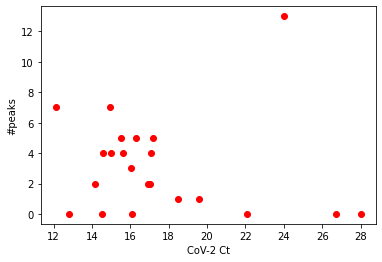

In [94]:
xs = qPCR.loc[:,'CoV-2 Ct']
ys = qPCR.loc[:,'#peaks']
labels = qPCR.index.tolist()
plt.plot(xs,ys,'ro')
plt.xlabel('CoV-2 Ct')
plt.ylabel('#peaks')

for x,y in zip(xs,ys):
    label = labels[y]
#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  ha='center'
#                 ) # horizontal alignment can be left, right or center

plt.show()

## 8. Define conserved peak
**Goal:** Subset peaks conserved between different samples 

This first method skipped. Merging results from different patients was challenging. However, I still report it here. 

**Method 1:** 
The logic of this part is: 
1. Convert `exomepeak` results from `bed12` to `bed6` 
2. Merge them from all samples 
3. Take _intersect_ of every samples (`-b`) with the merged peaks (`-a`)
4. Rename peaks from one transcript into uniq names
5. Write these peaks it into a fresh `bed6` format

In [125]:
%%bash
# merge beds from all samples 
cat exomepeak/virus/*/peak.bed | grep -v '^ *#' | bed12ToBed6 | sort -k1,1 -k2,2n | \
# merge all peaks 
mergeBed -i - -c 4 -o distinct | \
# get intersects of all samples in the merged bed file
bedtools intersect -wo -F 0.85 -a - -b exomepeak/virus/*/peak.bed | \
awk '{print $6"\t"$7"\t"$8"\t"$9"\t"".""\t"$11}' | sort -k2,2 | uniq > merge_peaks.bed
# rename peaks with unique names 
# awk -F "\t" '{OFS=FS}{$4=$4"::("$2"-"$3")"} 1' 

Complement coordinates

In [126]:
%%bash 
cat merge_peaks.bed | complementBed -i - -g virus/chrNameLength.txt > sudo_peaks.bed

In [146]:
# %reload_ext rpy2.ipython

In [145]:
# %%R
# library(rtracklayer)
# library(tidyverse)

# merge_peaks <- rtracklayer::import('merge_peaks.bed')
# merge_peaks$width <- width(merge_peaks)
# seqlevels(merge_peaks) <- 'chrCV'
# merge_peaks
# merge_peaks %>% data.frame# %>% arrange(desc(width))
# #select(4,6) %>% order( dataframe[,1] )

In [ ]:
#denote every blue position as 1 

**Method 2:** 

According to my conversation with Matt, 

> we are interested in things that look like sharp peaks on your picture

> why don’t you take this picture from above, denote every blue position as 1 and every white position as 0, sum it along the y axis and call peaks on that?

picture here is the visuallization of merged bed file from method 1. 

> you just run a peak caller on this sum vector

> let’s say the sum vector goes like `0 0 0 2 4 7 19 19 5 2 0 0 0 0`
then there is a peak in the middle right?
you can run a peak caller on that and then manually check the result

He suggests [span-peak-analyzer](https://research.jetbrains.org/groups/biolabs/tools/span-peak-analyzer). 
> well this one is semi-supervised, which means that the authors first manually chosen peaks that looks like peaks visually and usd them as a training set and the pic you showed to me looks like the peaks are well distinguishable visually so i think this is the right tool

I took a look into it. It has a genome browser for custom annotation toward semi-suppervised peak calling. As a lack of time, my current understanding is that this method is mainly implemented for well known genome references - not the COVID-19 genome at the moment. 

In [287]:
# # print ([f'{S}_FDR_0.025/peak.bed' for S in Samples])
# !ls virus_bam/*bam

In [286]:
# %%bash


# java -Xmx4G -jar /rumi/shams/abe/Workflows/SPAN_Peak_Analyzer/span-0.12.0.5096.jar analyze \
# -c 'exomepeak/virus/S0008_FDR_0.025/peak.bed','exomepeak/virus/S0009_FDR_0.025/peak.bed','exomepeak/virus/S0014_FDR_0.025/peak.bed', l'exomepeak/virus/S0017_FDR_0.025/peak.bed', 'exomepeak/virus/S0025_FDR_0.025/peak.bed', 'exomepeak/virus/S0026_FDR_0.025/peak.bed', 'exomepeak/virus/S0030_FDR_0.025/peak.bed', 'exomepeak/virus/S0042_FDR_0.025/peak.bed', 'exomepeak/virus/S0057_FDR_0.025/peak.bed', 'exomepeak/virus/S0085_FDR_0.025/peak.bed', 'exomepeak/virus/COV00075_FDR_0.025/peak.bed', 'exomepeak/virus/COV00079_FDR_0.025/peak.bed', 'exomepeak/virus/COV00084_FDR_0.025/peak.bed', 'exomepeak/virus/COV00087_FDR_0.025/peak.bed', 'exomepeak/virus/COV00093_FDR_0.025/peak.bed', 'exomepeak/virus/COV00106_FDR_0.025/peak.bed', 'exomepeak/virus/COV00397_FDR_0.025/peak.bed', 'exomepeak/virus/COV00413_FDR_0.025/peak.bed', 'exomepeak/virus/COV00417_FDR_0.025/peak.bed', 'exomepeak/virus/COV00419_FDR_0.025/peak.bed', 'exomepeak/virus/COV00422_FDR_0.025/peak.bed', 'exomepeak/virus/COV00432_FDR_0.025/peak.bed' \
# -- cs virus/chrNameLength.txt -d 


In [ ]:
# java -Xmx4G -jar span.jar analyze -t ChIP.bam -c Control.bam --cs Chrom.sizes -p Results.peak


**Method 3:** 

Instead, as we have discussed in Slack, I'm making a custom `bed` file for all windows in COVID19 genome with 100 bps and slide with 50 bps. Then, I'll use that for downstream steps. 

In [408]:
window_100_slide_50 = pd.DataFrame({
    'chromStart': pd.Series ([1] + list (range(50,29850,50)) ), 
    'chromEnd': pd.Series (list (range(100,29850 + 1,50)) + [29903] )
})
window_100_slide_50.insert(0,'# chr','MN908947.3')
window_100_slide_50['name'] = [f'win.{str(i)}' for i in range(window_100_slide_50.shape[0])]
window_100_slide_50['score'] = '.'
window_100_slide_50['strand'] = '+'

window_100_slide_50.to_csv('window_100_slide_50.bed', sep='\t', index=False)

## 9. Count features
> let's have a sliding window
of length fragment size/2
that slides across the genome

**Goal:** Count coverage in each IN and RIP sample (`bam` file) for downstream analysis

**Method:** 
`bamToBed` + `intersectBed` from `bedtools`

In [436]:
%%bash
mkdir -p window_100_slide_50_counts
# peak count
for f in virus_bam/*bam; do
    base=`basename $f`;
    out=${base/.bam/.fc};
    bamToBed -i $f | intersectBed -split -c -a window_100_slide_50.bed -b - | \
    awk '{ print $4 "\t" $7}' > window_100_slide_50_counts/$out; 
done

## 10. Motif analysis 
Extract peak sequences and search for `DRACH`, `RGAC`, `AAGAA` motifs.

[Logomaker](https://academic.oup.com/bioinformatics/article/36/7/2272/5671693) could be useful! 

In [437]:
DRACH = re.compile('[AGT][AG]AC[ACT]') 
RGAC = re.compile('[AG]GAC') 
AAGAA = re.compile('AAGAA') 

def write_fasta(name, reference = 'virus/coronavirus_2_isolate_Wuhan-Hu-1'):
    cmd = f'bedtools getfasta -name -s -fi {reference}.fasta -bed {name}.bed -split -fo {name}.fa'
    subprocess.call(cmd,shell=True)

def read_fasta(path):
    file = open(path)
    lines = file.read().splitlines()
    ids = [s[1:] for s in lines if '>' in s]
    n = [i for i,s in enumerate(lines) if '>' in s]
    n.append(len(lines))
    sequences = [''.join(lines[i+1:j]) for i,j in zip(n[:-1],n[1:])]
    file.close()
    fa = dict(zip(ids, sequences))
    return fa

def find_motifs(sam):
    motifs = [[f.split('::')[0], 
         len(DRACH.findall(sam[f])), 
         len(RGAC.findall(sam[f])), 
         len(AAGAA.findall(sam[f])),
         ','.join(DRACH.findall(sam[f]) + RGAC.findall(sam[f]) + AAGAA.findall(sam[f]))]
        for n, f in enumerate(sam)
    ]
    df = pd.DataFrame(motifs, columns=["loci","DRACH", "RGAC", "AAGAA","Sequence"])
    df = df.set_index('loci')
    return df

In [438]:
write_fasta('window_100_slide_50')

window_sequence = read_fasta('window_100_slide_50.fa')
window_motif_df = find_motifs(window_sequence)
window_motif_df.to_csv('Results/window_motif_analysis.txt', sep='\t')

Let's filter some peaks with `DRACH` and `RGAC` motifs for below analysis:

In [440]:
window_with_motifs = window_motif_df[
    (motif_df.DRACH > 2) # & (motif_df.DRACH < 8) 
    &
    (motif_df.RGAC > 2)
#     &
#     (motif_df.AAGAA > 0)
].index.tolist()
len(window_with_motifs)

10

## 11. m6A/input test of significance

We have discussed two scenarios with Hani to evaluate p-values for every peak in each samples (I'm following second option):
### 1st
- In IP samples, count reads mapping to the peak, and all peaks mapping to non-peak regions (i.e. background)
- In input, count the same, i.e. reads in the peak and non-peak
- that gives you a 2x2 contingency table, then calculate a p-value using Fisher's exact test

 _'non-peak' = it is total, reads mapping to all peaks_

### 2ed
- [ctest](https://github.com/lzcyzm/exomePeak/blob/master/R/ctest.R) function from exomepeak. [Here](https://github.com/lzcyzm/exomePeak/blob/master/R/peak.calling.module.R) is how that function is used

> `PEAK$loci2peak_merged=.get.peak.from.loci(READS_COUNT,ID,PARAMETERS)`

In [441]:
def read_counts(samples, path='window_100_slide_50_counts/'):
    '''
    Read raw counnt for IN and RIP into a pandas DataFrame    
    '''
    all_samples = np.concatenate([[N+'_IN',N+'_RIP'] for N in samples]).tolist()
    # Read count files as dataframe
    df_list = [
        pd.read_csv(f'{path}/{file}', header=None, sep='\t', index_col=0) 
        for file in [f'{name}.fc' for name in all_samples]
    ]
    # concatenate them together 
    data = pd.concat(df_list, axis=1)
    data.columns = all_samples
    
    names = data.index.tolist()
    return names, data

In [447]:
window_names, Counts = read_counts(Samples,path='window_100_slide_50_counts/')

Counts.to_csv('Results/window_100_slide_50_raw_counts.txt', sep='\t')

### Total number of reads:
1. Using `samtools` to convert `bam` files to `fastq` files 
2. total number of reads as: 
$$\frac{\text{Total number of lines}}{4}$$ 

virus

In [ ]:
%%bash --err error
mkdir -p total
echo 'sample, reads' > total/virus.txt
for f in virus_bam/*bam;
	do 
    name=`basename $f`
    name=${name/.bam/}
    declare -i a=`samtools fastq $f | wc -l`
    read=$((a / 4))
    echo $name,$read >> total/virus.txt
done

human 

In [ ]:
%%bash --err error
echo 'sample, reads' > total/human.txt
for f in */bam/*.bam; 
	do 
    name=`basename $f`
    name=${name/.bam/}
    declare -i a=`samtools fastq $f | wc -l`
    read=$((a / 4))
    echo $name,$read >> total/human.txt
done

ctrl m6A_neg

In [ ]:
%%bash --err error
echo 'sample, reads' > total/m6A_neg.txt
for f in */int_ctrl/virus/m6A_neg/*bam; 
	do 
    name=`basename $f`
    name=${name/_S[0-9]*/}
    name=${name/.bam/}
    declare -i a=`samtools fastq $f | wc -l`
    read=$((a / 4))
    echo $name,$read >> total/m6A_neg.txt
done

ctrl m6A_pos

In [ ]:
%%bash --err error
echo 'sample, reads' > total/m6A_pos.txt
for f in */int_ctrl/virus/m6A_pos/*bam; 
	do 
    name=`basename $f`
    name=${name/_S[0-9]*/}
    name=${name/.bam/}
    declare -i a=`samtools fastq $f | wc -l`
    read=$((a / 4))
    echo $name,$read >> total/m6A_pos.txt
done

In [576]:
aligned = ['human','virus','m6A_pos','m6A_neg']
total_df = pd.concat([pd.read_csv('total/'+a+'.txt', sep=',', index_col=0).sort_index() for a in aligned],axis=1)
total_df.columns = aligned

total_df.to_csv('total_reads.txt', sep='\t')

#### Read and normalize counts 
Log normalization of peak counts 

$$\log_2 \dfrac{
    \dfrac{\text{m6A counts in the peak}}{\text{m6A total counts}}
    }{
    \dfrac{\text{input counts in the peak}}{\text{input total counts}}
    }
    $$


In [ ]:
# def norm_counts(counts, samples, total_reads, norm='l1'):
#     all_samples = np.concatenate([[N+'_IN',N+'_RIP'] for N in samples]).tolist()    
#     peak_names = counts.index.tolist()
#     n_sam = len(all_samples)
#     # normalize
#     total = total_reads.loc[all_samples,].sum(axis=1)
#     total = np.array(total).T
#     data = np.array(counts[all_samples]) 
#     # log2 (RIP in peak / RIP total) / (IN in peak / IN total)
#     res = np.log2(
#         (
#             # RIP / RIP ctrl
#             data [:,np.array(range(1,n_sam,2))] 
#             /
#             total[np.array(range(1,n_sam,2))]
#         ) / (
#             # IN / IN ctrl
#             data [:,np.array(range(0,n_sam,2))] 
#             /
#             total[np.array(range(0,n_sam,2))]
#         )
#     )
#     # normalization by samples
#     if norm == None:
#         res = res
#     elif norm == 'min':
#         res = pp.minmax_scale(res, feature_range=(0, 1), axis=1)
#     elif norm == 'zscore':
#         res = stats.zscore(res, axis=0, ddof=1)
#     else:
#         res = pp.normalize(res, axis=1, norm=norm)
#     res_df = pd.DataFrame(data=res, columns=samples, index=peak_names)
#     return res_df


# Total = pd.read_csv('total_reads.txt', sep = '\t', index_col=0)  
# Norm_counts = norm_counts(Counts, Samples, Total, norm=None)
# Norm_counts.to_csv('norm_counts.txt', sep='\t')

Didn't work as we wanted! So, we ended up using `ctest` from `exomePeak` package. 
#### Implement and run `ctest`

In [364]:
%reload_ext rpy2.ipython

In [365]:
%%R 
# These function implemented from exomePeak R package. 

ctest <-  function(IP,INPUT,TOTAL_IP,TOTAL_INPUT,FOLD=1,minimal_counts_in_fdr = 10) {  
  # input check
  if (length(IP) != length(INPUT)) { 
      stop("The IP and INPUT of ctest must be of the same length.", call. = TRUE, domain = NULL) 
  }
  # replace 0 with 1
  IP=pmax(IP,1)
  INPUT=pmax(INPUT,1)
  
  # calculate p
  a=TOTAL_IP*FOLD
  b=TOTAL_INPUT
  p=a/(a+b)
  
  # get total observation
  total=IP+INPUT
  
  # cdf
  log.p=pbinom(IP-1, total, p, lower.tail = FALSE, log.p = TRUE)
  
  # calculate p  
  pvalues=exp(log.p)
  
  # calculate fdr
  log.fdr=log(p.adjust(pvalues, method = "fdr"))
  
  # with significant number of reads only
  ID=which( (IP+INPUT) > minimal_counts_in_fdr)
  log.fdr_sig=log(p.adjust(pvalues[ID], method = "fdr"))
  log.fdr[ID]=log.fdr_sig
  
  # fold enrichment
  log.fc=log((pmax(1,IP)/sum(IP))/(pmax(1,INPUT)/sum(INPUT)))
  
  # output result
  PW=list(log.p=log.p,log.fdr=log.fdr,log.fc=log.fc)
  return(PW)

}

peak.calling <- function(READS_COUNT,SAMPLE_ID){
    
    # check points comparison
    IP=READS_COUNT[,paste(SAMPLE_ID,'RIP',sep='_')]
    INPUT=READS_COUNT[,paste(SAMPLE_ID,'IN',sep='_')]
    
    PW = ctest(IP,INPUT,sum(IP),sum(INPUT))
    
    # output peaks
    return(PW)
}

In [376]:
def ctest_result(result, samples, peak_names):
    log_p  = pd.DataFrame([np.array(R[0]) for R in result], index=samples,columns=peak_names)
    log_fdr= pd.DataFrame([np.array(R[1]) for R in result], index=samples,columns=peak_names)
    log_fc = pd.DataFrame([np.array(R[2]) for R in result], index=samples,columns=peak_names)
    return log_p, log_fdr, log_fc

In [366]:
%%R -i Counts,Samples,Window_names -o RESULTS
Samples = unlist(Samples)
Window_names = unlist(Window_names)

RESULTS = list()
for (S in Window_names){RESULTS[[S]] = peak.calling(Counts,S)}

`ctest` results for every peaks in every samples are ready to go! 

In [379]:
Log_p_win, Log_fdr_win, Log_fc_win = ctest_result(RESULTS, Samples, Window_names)

In [386]:
Log_p_win.to_csv('Results/ctest_Log_p_win.txt', sep='\t')
Log_fdr_win.to_csv('Results/ctest_Log_fdr_win.txt', sep='\t')
Log_fc_win.to_csv('Results/ctest_Log_fc_win.txt', sep='\t')

## 12. Mutation analysis 
Ok! Now, I'm doing fuzzy-string-matching which explained well [here](https://www.datacamp.com/community/tutorials/fuzzy-string-python). `fuzzywuzzy` python package use [**Levenshtein Distance Equation**](https://medium.com/@ethannam/understanding-the-levenshtein-distance-equation-for-beginners-c4285a5604f0) to evaluate string matching. Here, we are trying to compare peak sequences with the sample WGS. 

I couldn't make it work appropriately! So, Hani shared his magic codes which I'm using that. More discussions at stackoverflow [here](https://stackoverflow.com/questions/2420412/search-for-string-allowing-for-one-mismatch-in-any-location-of-the-string).

In [574]:
def count_segment_mutation(segment_seq, whole_seq):
    mut_count = 0
    while 1 == 1: 
        check = re.findall("(%s){e<=%s}" % (segment_seq,mut_count),whole_seq) 
        if check == segment_seq:
            mut_count = mut_count + 1
        else:
            print (mut_count)
            break
    return mut_count

# m=re.findall("(AA){e<=1}", "CAAG") # means allow up to 1 error

# find_peak_mutation(sequence, n_mutation, whole_seq)

In [572]:
cos = ['GTAGATCCATTCACTA', 'GTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC']

In [575]:
# re.findall(, sample)
count_segment_mutation(cos[0],cos[1])
# count_segment_mutation

0


0

In [567]:
re.findall("(%s){e<=%s}" % (cos[0],3),cos[1])

['GTAGATCTGTTCTCTA']

Let's take peak sequences which defined earlier in this notebook as a pandas dataframe:

In [458]:
win_seq_list = [[w, window_sequence[s] ] for w,s in zip(window_names, window_sequence)]
sample_seq_df.sequence.tolist()


['NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTACACGGAACGTT

In [56]:
# peak sequences as dataframe
peak_seq_df = pd.DataFrame(
    list(peak_sequence.items()),
    columns = ['coordinate','sequence']
) 
# rename indices to peak names
peak_seq_df.index = [peak_seq_df.loc[p,'coordinate'].split('::')[0] for p in peak_seq_df.index]

Now, I read virus sequencing results in seprate pandas dataframe 

In [477]:
# WGS sequencing of patient samples as dataframe
files = glob.glob('virus_WGS/*.fasta')

sample_seq_df = pd.DataFrame(columns = ['sequence']) 
for f in files:
    sample = f.replace('virus_WGS/NM-n','').replace('.fasta','')
    sample_seq_df.loc[sample] = list(read_fasta(f).values())


16

# Sanity check
### [The Architecture of SARS-CoV-2 Transcriptome](https://www.cell.com/cell/pdf/S0092-8674(20)30406-2.pdf)


https://github.com/hyeshik/sars-cov-2-transcriptome/tree/master/figure-notebooks

Convert `gff` annotation to `bed` format:

In [338]:
anno = pd.read_csv(
    'sars-cov-2-transcriptome/reference/SARS-CoV-2-annotations.gff', 
    sep='\t', names=['chrom', 'type', 'name', 'start', 'end', 'x', 'y', 'z']
)

bed = anno.iloc[:,[3,4,2]]
bed.insert(0,'# chr','MN908947.3')
bed.insert(4,'score','.')
bed.insert(5,'strand','+')
bed.to_csv('sars-cov-2-transcriptome/reference/SARS-CoV-2-annotations.bed', sep='\t', header=False,index=False)

Write annotation sequences and analyse motifs:

In [387]:
write_fasta('sars-cov-2-transcriptome/reference/SARS-CoV-2-annotations')
cell_paper_peak_sequence = read_fasta('sars-cov-2-transcriptome/reference/SARS-CoV-2-annotations.fa')
cell_paper_motif_df = find_motifs(peak_sequence)
# motif_df.to_csv('sars-cov-2-transcriptome/reference/SARS-CoV-2-annotations.motif_analysis.txt', sep='\t')

Count read coverage to each the provided annotation

In [356]:
%%bash
mkdir -p sars-cov-2-transcriptome/reference/counts
# peak count
for f in virus_bam/*bam; do
    base=`basename $f`;
    out=${base/.bam/.fc};
    bamToBed -i $f | intersectBed -split -c \
    -a sars-cov-2-transcriptome/reference/SARS-CoV-2-annotations.bed -b - | \
    awk '{ print $4 "\t" $7}' > sars-cov-2-transcriptome/reference/counts/$out;
done

Read counts into a pandas dataframe:

In [389]:
PATH_to_cell_paper_Counts = 'sars-cov-2-transcriptome/reference/counts/'
cell_paper_Counts = read_counts(Samples, path=PATH_to_cell_paper_Counts)

cell_paper_annotations = peak_names(Samples, path=PATH_to_cell_paper_Counts)

In [359]:
%reload_ext rpy2.ipython

In [390]:
%%R -i cell_paper_Counts,Samples,cell_paper_annotations -o cell_paper_RESULTS
Samples = unlist(Samples)
cell_paper_annotations = unlist(cell_paper_annotations)

cell_paper_RESULTS = list()
for (S in Samples){cell_paper_RESULTS[[S]] = peak.calling(cell_paper_Counts,S)}

`ctest` results for every peaks in every samples are ready to go! 

In [393]:
Log_p_cell_paper, Log_fdr_cell_paper, Log_fc_cell_paper = ctest_result(cell_paper_RESULTS, Samples, cell_paper_annotations)

In [395]:
Log_p_cell_paper.to_csv('Results/ctest_Log_p_cell_paper.txt', sep='\t')
Log_fdr_cell_paper.to_csv('Results/ctest_Log_fdr_cell_paper.txt', sep='\t')
Log_fc_cell_paper.to_csv('Results/ctest_Log_fc_cell_paper.txt', sep='\t')